### **Uso de redes neurais para previsão hidrometeorológica de curto prazo**
###### O presente trabalho trata do uso de redes neurais para a previsão de curto prazo de nível de água na região serrana do Rio de Janeiro. Com os resultados obtidos neste trabalho foi possível concluir que é possível prever o nível de água do rio com boa acurácia.

#### Imports

In [1]:
%tensorflow_version 2.x

import pandas as pd
import numpy as np

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.models import Sequential
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K

import matplotlib.pyplot as plt
import datetime
from numpy.random import seed
from time import time
import tensorflow as tf


#### Funções auxiliares

Foram criadas algumas funções para facilitar a execução dos experimentos.
* read_csv_dataset: Carrega o dataset de um arquivo CSV
* get_max_nse: Para retornar o valor máximo do NSE
* plot_history: Para plotar o desempenho da rede

In [2]:
data_path = 'https://raw.githubusercontent.com/cpfreitas/redes_neurais/master/data/'

def read_csv_dataset(source):
  df = pd.read_csv('{}/{}.csv'.format(data_path, source), parse_dates=['data_hora'])
  df = df.set_index('data_hora')
  return df

def get_max_nse(history):
    validation = history.history["val_nse"]
    ymax = max(validation)
    return "Max NSE ≈ " + "%.6f" % ymax

def get_metrics(history):
    validation_rmse = history.history["val_rmse"]
    validation_nse = history.history["val_nse"]
    return min(validation_rmse), max(validation_nse) 

def plot_history(history, title):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

  fig.suptitle(title)
 
  ax1.plot(history.history['nse'], label='train')
  ax1.plot(history.history['val_nse'], label='test')
  ax1.set_ylabel('nse')
  ax1.set_xlabel('epoch')

  ax2.plot(history.history['loss'], label='train')
  ax2.plot(history.history['val_loss'], label='test')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')
  
  ax1.text(
        0.97,
        0.97,
        get_max_nse(history),
        horizontalalignment="right",
        verticalalignment="top",
        transform=ax1.transAxes,
        fontsize=18,
    )
  plt.legend()
  plt.show()

#### Carrega o dataset com os dados de estação

In [3]:
data = read_csv_dataset('data_final')

data.describe()

,chuva_Olaria,nivel_Olaria,chuva_Suspiro,nivel_Suspiro,chuva_ConselheiroPaulino,nivel_ConselheiroPaulino,chuva_VendaDasPedras,nivel_VendaDasPedras,chuva_Ypu,nivel_Ypu
count,46080.000000,46080.000000,46080.000000,46080.000000,46080.000000,46080.000000,46080.000000,46080.000000,46080.000000,46080.000000
mean,0.050668,0.683814,0.042669,0.835646,0.055278,1.584493,0.051978,0.666643,0.049796,0.617024
std,0.431721,0.128411,0.435874,0.302345,0.514139,0.150803,0.550568,0.159374,0.439705,0.176312
min,0.000000,0.490000,0.000000,0.430000,0.000000,1.420000,0.000000,0.490000,0.000000,0.310000
25%,0.000000,0.590000,0.000000,0.640000,0.000000,1.490000,0.000000,0.560000,0.000000,0.520000
50%,0.000000,0.650000,0.000000,0.790000,0.000000,1.550000,0.000000,0.620000,0.000000,0.570000
75%,0.000000,0.740000,0.000000,0.940000,0.000000,1.630000,0.000000,0.710000,0.000000,0.660000
max,20.400000,2.180000,41.400000,4.540000,21.600000,3.500000,64.200000,2.300000,22.000000,2.550000


#### Normaliza e separa os dados de entrada e saida

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))


# Considera como entrada os dados de chuva e nivel 
# de todas as estacoes para o tempo t
x = scaler.fit_transform(data[['chuva_Olaria', 'nivel_Olaria',
          'chuva_VendaDasPedras', 'nivel_VendaDasPedras',
          'chuva_Suspiro', 'nivel_Suspiro',
          'chuva_Ypu', 'nivel_Ypu',
          'chuva_ConselheiroPaulino', 'nivel_ConselheiroPaulino']].values)

#Considera como saida os dados de nivel para a estacao de conselheiro paulino
# para o tempo t + 1
#y = x[:,1::2]
y = x[:,9]

date_split = datetime.datetime(year=2013, month=2, day=1, hour=0, minute=0)
train_index = data.loc[data.index<date_split]

i = 1

## Remove o ultimo tempo do df de x e o primeiro do df de y
in_data = x[:-i]
out_data = y[i:]

print(in_data.shape)
print(out_data.shape)

#Separa o dataset em treinamento, validacao e teste
x_train_without_test = in_data[0:train_index.shape[0],]
y_train_without_test = out_data[0:train_index.shape[0],]

x_test = in_data[train_index.shape[0]:,]
y_test = out_data[train_index.shape[0]:,]

x_train, x_val, y_train, y_val = train_test_split(x_train_without_test, y_train_without_test,
                                                  test_size=0.2, random_state=seed_number)


(46079, 10)
(46079,)


In [5]:
def nse(y_true, y_pred):
	return 1 - (K.sum((y_pred - y_true)**2)/
                         K.sum((y_true - K.mean(y_true))**2)) 

def rmse(y_true, y_pred):
	return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

#### Definição e treinamento da rede

In [6]:
input_dim = x_train.shape[1]

model = Sequential()

model.add(Dense(input_dim,input_shape=(input_dim,),activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[rmse, nse])
model.summary()

history = model.fit(x_train, y_train, epochs=100, batch_size=1000,
                        validation_data=(x_val, y_val))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
33/33 [==============================] - 0s 6ms/step - loss: 0.0291 - rmse: 0.0291 - nse: 0.2683 - val_loss: 0.0247 - val_rmse: 0.0247 - val_nse: 0.4249
Epoch 2/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0238 - rmse: 0.0238 - nse: 0.5166 - val_loss: 0.0213 - val_rmse: 0.0213 - val_nse: 0.6067
Epoch 3/100
33/33 [==============================] - 0s 2m

(0.0013222420820966363, 0.9944629669189453)


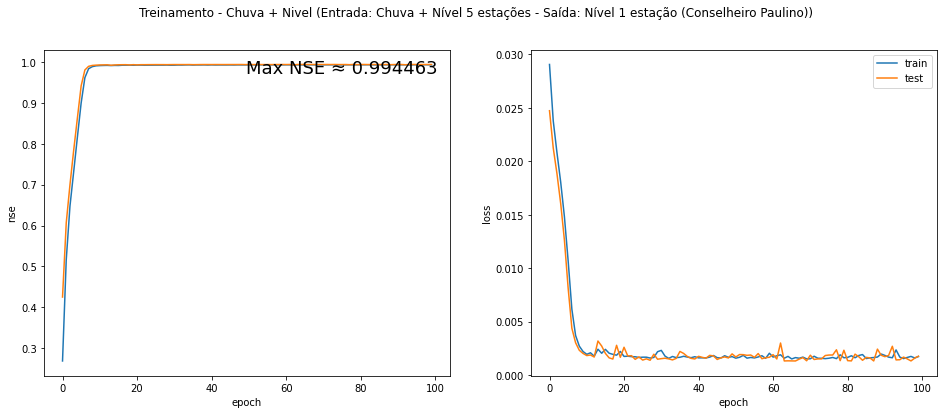

In [7]:
print(get_metrics(history))
plot_history(history, 'Treinamento - Chuva + Nivel (Entrada: Chuva + Nível 5 estações - Saída: Nível 1 estação (Conselheiro Paulino))')


(4991, 10) (4991, 10)
4991


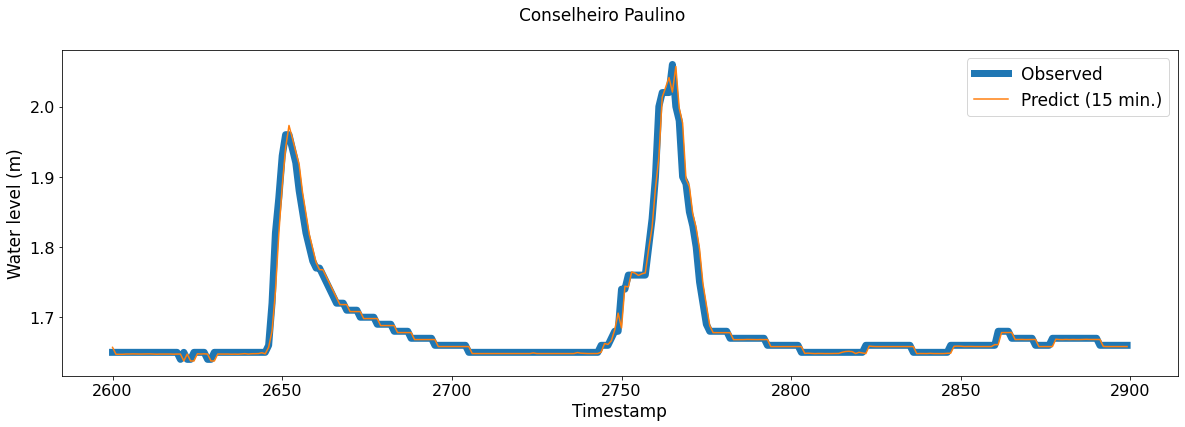

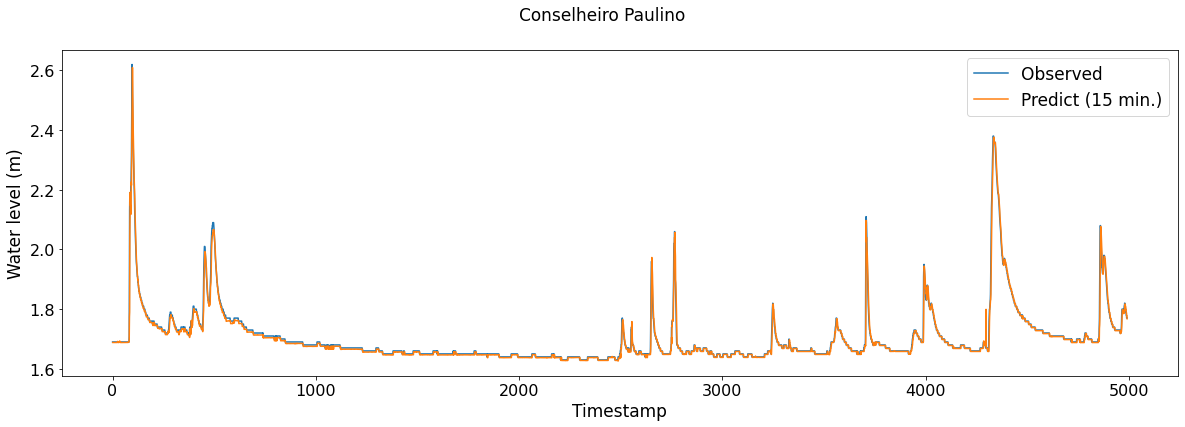

In [9]:
predict_values = model.predict(x_test)

predict_dataset = np.zeros(shape=(len(predict_values), 10))
predict_dataset[:,] = predict_values
predict_dataset = scaler.inverse_transform(predict_dataset)

test_dataset = np.zeros(shape=(len(y_test), 10))
test_dataset[:,9] = y_test
test_dataset = scaler.inverse_transform(test_dataset)

print(predict_dataset.shape, test_dataset.shape)


n_size = 300
total_size = predict_dataset.shape[0]
print(total_size)

start = 2600
fig, (ax1) = plt.subplots(1,1, figsize=(20, 6))
plt.plot(range(start,n_size+start), test_dataset[:,9][start:n_size+start], label='Observed', linewidth=7.0)
plt.plot(range(start,n_size+start), predict_dataset[:,9][start:(n_size+start)], label='Predict ('+ str(i*15) + ' min.)')
plt.legend(fontsize=17)
plt.tick_params(labelsize=16)
plt.suptitle('Conselheiro Paulino', fontsize=17)
ax1.set_ylabel('Water level (m)', fontsize=17)
ax1.set_xlabel('Timestamp',fontsize=17)

plt.show()


fig2, (ax1) = plt.subplots(1,1, figsize=(20, 6))
plt.plot(range(total_size), test_dataset[:,9][:total_size], label='Observed')
plt.plot(range(i,total_size+i), predict_dataset[:,9][:total_size], label='Predict (15 min.)')
plt.legend(fontsize=17)
plt.tick_params(labelsize=16)
plt.suptitle('Conselheiro Paulino', fontsize=17)
ax1.set_ylabel('Water level (m)', fontsize=17)
ax1.set_xlabel('Timestamp',fontsize=17)

plt.show()

